Successfully loaded 50 whale accounts for deterministic sweep.
--- Simulation Summary ---
Systemic Liquidation Cliff identified at: -52.0% Price Drop
Potential Bad Debt Triggered at Cliff: $323.77 Million


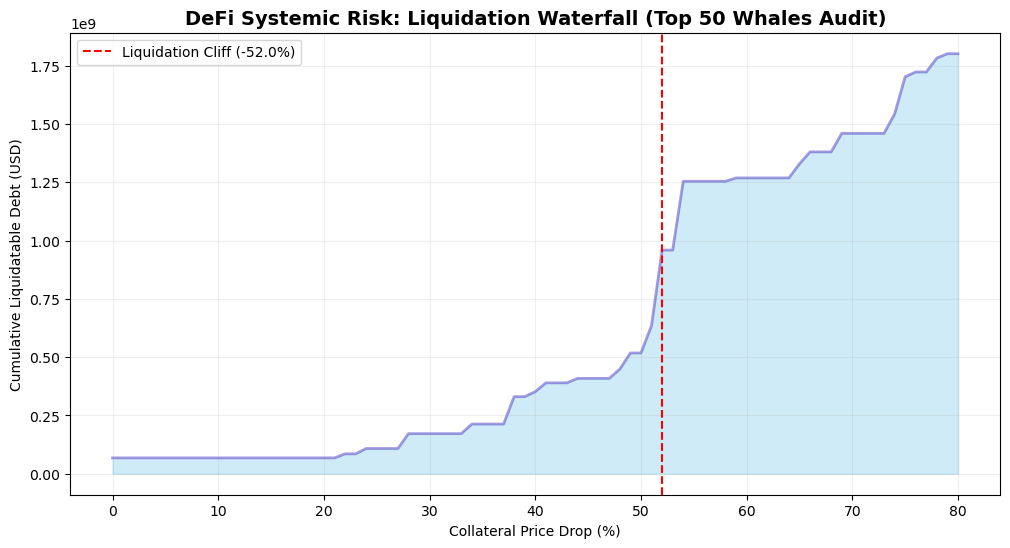

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load Audit Data (Top 50 Whales from SQL Pareto Analysis) ---
# Data source: 12_whale_liquidation_triggers.csv
# This file contains the results of the Systemic Concentration Audit.
try:
    df_whales = pd.read_csv('12_whale_liquidation_triggers.csv')
    print(f"Successfully loaded {len(df_whales)} whale accounts for deterministic sweep.")
except FileNotFoundError:
    print("Error: 12_whale_liquidation_triggers.csv not found. Please ensure Phase 12 SQL results are exported.")

# --- 2. Define the Liquidation Sweep Logic ---
def generate_liquidation_waterfall(df):
    waterfall_data = []
    
    # Sweep price drop from 0% (current) to 80% (extreme crash)
    # Using 1% increments for high granularity (Professor's 'continuous' requirement)
    for drop_pct in range(0, 81, 1):
        drop_ratio = drop_pct / 100
        total_liquidated_debt = 0
        
        for index, whale in df.iterrows():
            # In Aave V3, Liquidation occurs when Health Factor (HF) < 1.0
            # New HF = Current HF * (1 - Price Drop)
            # This is mathematically equivalent to LTV hitting the Threshold.
            if whale['current_hf'] > 0:
                future_hf = whale['current_hf'] * (1 - drop_ratio)
                
                if future_hf < 1.0:
                    total_liquidated_debt += whale['outstanding_debt_usdt']
        
        waterfall_data.append({
            'Price_Drop_Pct': drop_pct,
            'Liquidated_Debt_USD': total_liquidated_debt
        })
        
    return pd.DataFrame(waterfall_data)

# --- 3. Run Deterministic Simulation ---
df_waterfall = generate_liquidation_waterfall(df_whales)

# --- 4. Identify the "Liquidation Cliff" ---
# The cliff is the point where liquidated debt increases most sharply.
df_waterfall['Debt_Increase'] = df_waterfall['Liquidated_Debt_USD'].diff().fillna(0)
cliff_point = df_waterfall.loc[df_waterfall['Debt_Increase'].idxmax()]

print(f"--- Simulation Summary ---")
print(f"Systemic Liquidation Cliff identified at: -{cliff_point['Price_Drop_Pct']}% Price Drop")
print(f"Potential Bad Debt Triggered at Cliff: ${cliff_point['Debt_Increase']/1e6:.2f} Million")

# --- 5. Visualization: The Waterfall Chart ---
plt.figure(figsize=(12, 6))
plt.fill_between(df_waterfall['Price_Drop_Pct'], df_waterfall['Liquidated_Debt_USD'], color="skyblue", alpha=0.4)
plt.plot(df_waterfall['Price_Drop_Pct'], df_waterfall['Liquidated_Debt_USD'], color="Slateblue", alpha=0.6, linewidth=2)

# Mark the Cliff
plt.axvline(x=cliff_point['Price_Drop_Pct'], color='red', linestyle='--', label=f"Liquidation Cliff (-{cliff_point['Price_Drop_Pct']}%)")

plt.title('DeFi Systemic Risk: Liquidation Waterfall (Top 50 Whales Audit)', fontsize=14, fontweight='bold')
plt.xlabel('Collateral Price Drop (%)')
plt.ylabel('Cumulative Liquidatable Debt (USD)')
plt.grid(True, alpha=0.2)
plt.legend()
plt.savefig('liquidation_waterfall_plot.png')
plt.show()

# --- 6. Export for Audit Report ---
df_waterfall.to_csv('04_liquidation_waterfall_results.csv', index=False)